### UNet CNN Image Prediction Model

In [3]:
#####################################################
## UNet CNN Image Model
## Imports
##
## Author: Matthew Yeseta
#####################################################

import tensorflow as tf
from tensorflow.keras import layers, callbacks
from sklearn.model_selection import train_test_split
import os
import glob
from PIL import Image
import numpy as np

unet_prediction_output_dir = "unet_predicted_images"  


##### Explanation of the Algorithm

The UNet CNN model is a convolutional neural network (CNN) architecture designed for image segmentation tasks. Image segmentation involves classifying each pixel in an image, and UNet is widely used in fields like medical imaging where accurate pixel-level predictions are necessary.

This model architecture follows a typical encoder-decoder pattern, where:

The encoder (or downsampling path) progressively reduces the spatial dimensions of the input while capturing essential features through convolutional layers.
The decoder (or upsampling path) reconstructs the spatial dimensions by upsampling the encoded features to match the original input size. Additionally, it incorporates skip connections from the encoder to retain spatial information lost during downsampling.
In this code, the encoder part consists of several Conv2D layers to extract features, followed by BatchNormalization to stabilize learning and speed up convergence. The decoder part uses Conv2DTranspose layers to upsample the feature maps, with Dropout to prevent overfitting. Skip connections allow the model to combine information from both the downsampling and upsampling paths to make precise predictions. Finally, a Conv2D layer with a sigmoid activation is used to output the segmentation mask, suitable for binary segmentation tasks.

### Explanation of the Algorithm and How It Works in This Model
UNet CNN model, an architecture widely used for image segmentation tasks. The model is built as an encoder-decoder architecture with skip connections, allowing the network to combine high-level features (from the deeper layers) and low-level spatial information (from earlier layers).

#### Encoder (Downsampling Path):

The model starts with an input image of a given shape (e.g., 128x128x3 for RGB images).
The downsampling path consists of Conv2D layers with ReLU activations that extract features while reducing the spatial dimensions through striding.
Each layer is followed by BatchNormalization to normalize the output, ensuring stable training and faster convergence. The outputs from each step are stored in a skip connection for later use in the decoder.

#### Decoder (Upsampling Path):

After downsampling, the decoder begins upsampling the feature maps using Conv2DTranspose layers. These layers increase the spatial resolution to restore the original image size.
The skip connections from the encoder are concatenated with the upsampled feature maps, allowing the model to combine detailed spatial information from the encoder with the high-level features from the decoder.
The Dropout layers in the decoder help reduce overfitting during training by randomly deactivating neurons during the learning process.

#### Final Output Layer:

The final Conv2D layer reduces the number of output channels to 1, which is suitable for binary segmentation tasks (e.g., foreground vs. background in an image).
The sigmoid activation ensures the output values are in the range of [0, 1], which can be interpreted as probabilities for each pixel being part of a specific class (binary segmentation).
This architecture allows for effective pixel-wise predictions in segmentation tasks by combining both high-level and low-level features using skip connections.

In [4]:
#####################################################
## UNet CNN Image Model
## Class Name: Unnet_CNN()
##
## Author: Matthew Yeseta
#####################################################
class UNet_CNN:
    # Constructor to initialize the input and output shapes of the model.
    def __init__(self, input_shape=(128, 128, 3), output_channels=1):  
        # input_shape: defines the shape of the input image (128x128 with 3 color channels by default).
        # output_channels: defines the number of output channels (1 for binary segmentation).
        self.input_shape = input_shape
        self.output_channels = output_channels

    # Method to build the UNet model.
    def build_model(self):
        # Input layer: Takes input images of shape specified by input_shape.
        inputs = tf.keras.layers.Input(shape=self.input_shape)

        # Encoder (downsampling stack):
        # Downsampling layers with Conv2D and BatchNormalization.
        down_stack = [
            layers.Conv2D(64, 3, strides=2, padding='same', activation='relu'),  # Downsampling by reducing spatial dimensions with 64 filters.
            layers.BatchNormalization(),  # Normalizes output to stabilize and speed up learning.
            layers.Conv2D(128, 3, strides=2, padding='same', activation='relu'),  # Further downsampling with 128 filters.
            layers.BatchNormalization(),
            layers.Conv2D(256, 3, strides=2, padding='same', activation='relu'),  # Further downsampling with 256 filters.
            layers.BatchNormalization(),
        ]

        # Initializing x with the input image and skips as an empty list to store skip connections.
        x = inputs
        skips = []

        # Apply each downsampling layer (from down_stack) to the input image.
        for down in down_stack:
            x = down(x)  # Pass x through the current layer in the down_stack.
            skips.append(x)  # Store each output for use in skip connections.

        # Reverse the skip connections list (excluding the last downsampled layer).
        skips = reversed(skips[:-1])

        # Decoder (upsampling stack):
        # Transposed convolutions to increase spatial dimensions and recover original input size.
        up_stack = [
            layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu'),  # Upsampling with 128 filters.
            layers.BatchNormalization(),  # Batch normalization after upsampling.
            layers.Dropout(0.3),  # Dropout to prevent overfitting.
            layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'),  # Further upsampling with 64 filters.
            layers.BatchNormalization(),
            layers.Dropout(0.3),
        ]

        # Upsampling and concatenating skip connections from the encoder.
        for up, skip in zip(up_stack, skips):
            x = up(x)  # Upsample the feature map.
            # Resize skip connection if necessary (e.g., due to minor spatial dimension mismatches).
            if x.shape[1] != skip.shape[1] or x.shape[2] != skip.shape[2]:
                skip = tf.image.resize(skip, size=(x.shape[1], x.shape[2]))  # Resize skip connection to match upsampled feature map.
            x = tf.concat([x, skip], axis=-1)  # Concatenate upsampled feature map and skip connection along the channel axis.

        # Final output layer:
        # Apply a Conv2D layer to reduce the number of output channels to 1 (for binary segmentation).
        output = layers.Conv2D(1, 1, activation='sigmoid')(x)  # Sigmoid activation for binary mask prediction.

        # Return the complete model (Keras Model with specified inputs and outputs).
        return tf.keras.Model(inputs=inputs, outputs=output)


##### Explanation of the Algorithm

This tensor_create_imageset fuction, that processes images and their corresponding masks, resizes them, and prepares them as a TensorFlow dataset for further use in deep learning tasks such as image segmentation.

The function takes two arguments: the paths to the folder containing the images and the masks (which are used to label regions of the images). It first collects all image files and mask files from the specified directories, ensuring that each image has a corresponding mask. The images and masks are resized to a consistent size (128x128) to standardize the dataset. Each image is converted into a normalized NumPy array (scaled between 0 and 1) for model compatibility. Finally, the function converts the processed image and mask arrays into TensorFlow tensors and packages them into a TensorFlow dataset that can be used to feed data into a model for training or inference.

##### Explanation of the Algorithm and How It Works in This Model

##### File Collection: 
The function begins by collecting image and mask files from the given directories using glob.glob. This ensures that all .bmp or .BMP files are collected.

#### Filename Matching: 
Extracts the filenames without extensions and finds matching image-mask pairs to ensure each image has a corresponding mask. This is crucial for segmentation tasks, where each image needs a mask to define which parts belong to specific objects or regions.

##### Image and Mask Processing: 
The function opens each image and mask, converts the image to RGB (3-channel) format and the mask to grayscale (single channel), resizes both to 128x128 pixels, and converts them into normalized NumPy arrays. The pixel values are normalized to a range of 0 to 1, which is common in deep learning models to speed up training and improve performance.

#### Tensor Conversion: After processing all images and masks, the function converts the lists of image and mask arrays into TensorFlow tensors.

#### Dataset Creation: 
Finally, the function creates a TensorFlow dataset that pairs each image with its corresponding mask, which is useful for training image segmentation models that take both input images and output masks as labels.

This algorithm efficiently prepares a dataset for image segmentation or other vision-related tasks by creating a pipeline to process, normalize, and convert images and masks into a format usable by deep learning models.

In [5]:
#####################################################
## UNet CNN Image Model
## Class Name: tensor_create_imageset()
##
## Author: Matthew Yeseta
#####################################################
def tensor_create_imageset(image_path, masked_image_path):
    # Define a function that takes two inputs: one for the image directory and one for the mask directory.
    images = []
    masks = []

    # Collects all .bmp and .BMP image files from the given image path
    image_files = glob.glob(os.path.join(image_path, "*.bmp")) + glob.glob(os.path.join(image_path, "*.BMP"))
    # Collects all .bmp and .BMP mask files from the given mask path
    mask_files = glob.glob(os.path.join(masked_image_path, "*.bmp")) + glob.glob(os.path.join(masked_image_path, "*.BMP"))

    # Create dictionaries that map the base filename (without extension) to the full file path for images and masks
    image_names = {os.path.basename(f).split('.')[0]: f for f in image_files}
    mask_names = {os.path.basename(f).split('.')[0]: f for f in mask_files}

    # Find the intersection of image and mask filenames to ensure each image has a corresponding mask
    matching_names = image_names.keys() & mask_names.keys()
    print(f"Found {len(matching_names)} matching image-mask pairs.")

    # Raise an error if no matching image-mask pairs are found
    if len(matching_names) == 0:
        raise ValueError("No matching image-mask pairs found.")

    # Assert that the number of image files matches the number of mask files (sanity check)
    assert len(image_files) == len(mask_files), "Mismatch between number of images and masks."

    # Iterate over the image and mask files simultaneously
    for img_file, mask_file in zip(image_files, mask_files):
        # Open the image file and convert it to RGB format (3 color channels)
        img = Image.open(img_file).convert('RGB')
        # Open the mask file and convert it to grayscale (1 channel)
        mask = Image.open(mask_file).convert('L')
        
        # Resize the image and mask to 128x128 pixels
        img = img.resize((128, 128))
        mask = mask.resize((128, 128))

        # Convert the resized images and masks into NumPy arrays and normalize pixel values to [0, 1]
        img_array = np.array(img, dtype=np.float32) / 255.0
        mask_array = np.array(mask, dtype=np.float32) / 255.0

        # Append the processed image and mask arrays to their respective lists
        images.append(img_array)
        masks.append(mask_array)

    # Convert the lists of image and mask arrays into TensorFlow tensors
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    masks = tf.convert_to_tensor(masks, dtype=tf.float32)

    # Create a TensorFlow dataset from the image and mask tensors, pairing each image with its corresponding mask
    tf_set = tf.data.Dataset.from_tensor_slices((images, masks))
    
    # Return the created TensorFlow dataset
    return tf_set


##### Explanation of the Algorithm

The Trainer function is designed to manage the training, evaluation, and prediction-saving tasks of a machine learning model in TensorFlow, specifically for tasks that involve image-based segmentation or classification (as inferred from the use of masks and metrics like Dice coefficient and IoU). The class encapsulates the setup of the model, optimizer, and loss function, and provides methods to train the model, evaluate it on test data, and save prediction results to disk for visualization.

The class constructor (__init__) initializes the model with an optimizer (defaulting to Adam), a loss function (defaulting to binary cross-entropy, which is common for binary classification problems), and additional evaluation metrics like Dice coefficient and Intersection over Union (IoU), which are often used in image segmentation tasks.
 
The train method orchestrates the training process, allowing the model to be trained for a specified number of epochs and steps, using both training and validation datasets.
 
The evaluate method is used to measure the model's performance on a test dataset, returning metrics such as accuracy and loss.
 
The save_predictions method handles the process of making predictions on a test set, converting them into images, and saving these along with the original images and masks. This allows for easy visualization of the results.
 
The overall workflow is typical for image-based machine learning, with the added benefit of using specific metrics that are crucial in tasks like medical image analysis or object segmentation.

##### Key Points of the Algorithm:

##### Initialization: 
The class sets up the model with a specified optimizer, loss function, and metrics. If not provided, defaults are used (Adam optimizer, binary cross-entropy loss, and common segmentation metrics like 

##### Dice coefficient and IoU).
Training: The train method handles the iterative process of training the model for a set number of epochs. It tracks the progress through the history object, which stores losses and metrics.

#### Evaluation: 
The evaluate method assesses the model's performance on a test dataset, calculating metrics such as loss and accuracy.
#### Prediction Saving: 
The save_predictions method predicts masks for test images, then saves the original image, ground truth mask, and predicted mask as PNG files. This helps visualize how well the model has learned to segment the images.
 
By understanding this flow, you can modify and expand on the model's behavior based on the type of data and task, while ensuring the necessary steps are carried out correctly.

In [5]:
#####################################################
## UNet CNN Image Model
## Class Name: Trainer()
##
## Author: Matthew Yeseta
#####################################################
class Trainer:  
    # This class handles the training, evaluation, and prediction saving for a model.

    def __init__(self, model, optimizer=None, loss_fn=None, metrics=None):
        # Initialize the Trainer class with a model, optimizer, loss function, and evaluation metrics.

        self.model = model  # Store the model provided as a parameter.

        # If no optimizer is provided, use Adam as the default optimizer.
        self.optimizer = optimizer if optimizer else tf.keras.optimizers.Adam()

        # If no loss function is provided, use Binary Crossentropy as the default loss function.
        self.loss_fn = loss_fn if loss_fn else tf.keras.losses.BinaryCrossentropy()

        # If no custom metrics are provided, use default ones (Dice coefficient, IoU, and Binary Accuracy).
        self.metrics = metrics if metrics else [
            LossesMetrics.dice_coef,  # Custom metric for measuring Dice coefficient (image segmentation performance).
            LossesMetrics.iou_metric,  # Custom metric for Intersection over Union (IoU), another segmentation metric.
            tf.keras.metrics.BinaryAccuracy()  # Built-in metric to measure binary classification accuracy.
        ]

        # Compile the model with the specified optimizer, loss function, and metrics.
        self.model.compile(optimizer=self.optimizer, loss=self.loss_fn, metrics=self.metrics)

    def train(self, train_batches, val_batches, steps_per_epoch, validation_steps, epochs=7):
        # Train the model with the provided training and validation data over a number of epochs.

        history = self.model.fit(
            train_batches,  # Training data (images and labels/masks).
            validation_data=val_batches,  # Validation data to evaluate performance during training.
            steps_per_epoch=steps_per_epoch,  # Number of batches to process per epoch.
            validation_steps=validation_steps,  # Number of validation batches per epoch.
            epochs=epochs  # Number of epochs to train the model (default is 7).
        )
        return history  # Return the training history, which contains loss and metrics for each epoch.

    def evaluate(self, test_batches):
        # Evaluate the model on the provided test data and return the evaluation metrics.
        return self.model.evaluate(test_batches)

    def save_predictions(self, test_batches, output_dir):
        # Predict and save images, masks, and predicted masks from the test data.
        
        for idx, (images, masks) in enumerate(test_batches):
            # Loop over the test batches to get the images and corresponding masks.

            predictions = self.model.predict(images)  
            # Predict the masks for the images using the model.

            for i in range(len(predictions)):
                # Loop through each predicted mask in the batch.

                predicted_mask = np.squeeze(predictions[i])  
                # Remove unnecessary dimensions from the predicted mask (usually the batch dimension).
                
                original_image = (images[i].numpy() * 255).astype(np.uint8)  
                # Convert the original image from tensor to a format suitable for saving (scale to [0, 255] and cast to uint8).

                mask = np.squeeze(masks[i].numpy())  
                # Remove unnecessary dimensions from the true mask and convert it to a format suitable for saving.

                mask = (mask * 255).astype(np.uint8)  
                # Scale the mask values to [0, 255] for image saving.

                # Save the original image, true mask, and predicted mask to the specified output directory.
                Image.fromarray(original_image).save(f"{output_dir}/image_{idx}_{i}.png")  
                Image.fromarray(mask).save(f"{output_dir}/mask_{idx}_{i}.png")
                Image.fromarray((predicted_mask * 255).astype(np.uint8)).save(f"{output_dir}/prediction_{idx}_{i}.png")


##### Explanation of the Algorithm

Class code defines a class predict_images responsible for training and evaluating a model for image segmentation. The model utilizes a U-Net architecture, which is commonly used in medical image segmentation and other computer vision tasks involving pixel-wise classification. The class is initialized with the paths to input images and their corresponding masks, the number of output channels, and the number of epochs for training.

##### The main components

#### Data Preparation: 
The prepare_data method handles loading the images and corresponding masks, resizing them to a fixed size, and splitting the data into training, validation, and test sets. TensorFlow's Dataset API is used to create batches and optimize data loading.

#### Model Training and Evaluation: 
The run method first prepares the data, then builds and trains the U-Net model using a custom trainer class. It evaluates the model on the test set using metrics such as loss, Dice coefficient (a measure of overlap between the predicted and ground truth masks), and Intersection over Union (IoU). The model’s predictions are saved to a specified directory for future analysis.

#### The U-Net architecture
Class is well-suited for this task because it captures both global and local features, making it effective for tasks that require precise localization like segmentation. The model is trained with the provided images and masks, and once trained, it generates predictions on the test set and outputs performance metrics.

The U-Net architecture is used for segmentation tasks, while TensorFlow is leveraged for efficient data handling, batching, and training. The model's performance is evaluated using Dice coefficient and IoU, both commonly used metrics in image segmentation.


In [6]:
#####################################################
## UNet CNN Image Model
## Class Name: predict_images()
##
## Author: Matthew Yeseta
#####################################################
class predict_images:
    # Constructor for the predict_images class
    # Initializes paths for images and masks, the number of output channels, and the number of training epochs
    def __init__(self, image_path, masked_image_path, output_channels=1, number_epochs=1):
        self.image_path = image_path  # Path to the input images
        self.masked_image_path = masked_image_path  # Path to the corresponding masks (labels)
        self.output_channels = output_channels  # Number of output channels for the model (e.g., for binary or multi-class segmentation)
        self.epochs = number_epochs  # Number of epochs to train the model

    # Method to prepare the dataset for training, validation, and testing
    def prepare_data(self):
        # Create a dataset of images and masks
        imageset = tensor_create_imageset(self.image_path, self.masked_image_path)  
        
        # Separate the images and masks into different lists
        images = [image for image, mask in imageset]  
        labels = [mask for image, mask in imageset]  

        # Check if images or labels are empty, raise an error if none are found
        if len(images) == 0 or len(labels) == 0:
            raise ValueError("No images or labels found in the dataset.")

        # Expand the dimensions of the masks if they are 2D to make them 3D (needed for some TensorFlow operations)
        labels_expanded = [tf.expand_dims(mask, axis=-1) if mask.shape.ndims == 2 else mask for mask in labels]
        
        # Resize the masks to a uniform size (64x64) for model training
        labels_resized = [tf.image.resize(mask, (64, 64)) for mask in labels_expanded]

        # Split the dataset into training/validation and test sets (90% train/val, 10% test)
        X_trainval, X_test, Y_trainval, Y_test = train_test_split(images, labels_resized, test_size=0.1, random_state=42)
        
        # Further split the train/val set into training and validation sets (80% training, 20% validation)
        X_train, X_val, Y_train, Y_val = train_test_split(X_trainval, Y_trainval, test_size=0.2, random_state=42)

        # Create a TensorFlow dataset from the training data, shuffle, batch, and prefetch it for performance
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
        train_batches = (
            train_dataset.cache().shuffle(1000).batch(64).repeat().prefetch(buffer_size=tf.data.AUTOTUNE)
        )

        # Create a dataset for validation data
        val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
        val_batches = val_dataset.batch(64)  # Batch validation data

        # Create a dataset for test data
        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
        test_batches = test_dataset.batch(64)  # Batch test data

        # Return the batched datasets and the sizes of the training and validation sets
        return train_batches, val_batches, test_batches, len(X_train), len(X_val)

    # Main method to run the training and evaluation process
    def run(self):
        # Prepare data by calling the prepare_data method
        train_batches, val_batches, test_batches, train_size, val_size = self.prepare_data()

        # Calculate the number of steps per epoch (based on batch size of 64)
        steps_per_epoch = max(train_size // 64, 1)
        validation_steps = max(val_size // 64, 1)

        # Initialize the U-Net model with the specified number of output channels
        unet = UNet_CNN(output_channels=self.output_channels)
        model = unet.build_model()  # Build the U-Net model architecture

        # Initialize the Trainer class to handle model training
        trainer = Trainer(model=model)
        
        # Train the model using the training and validation batches, defined number of steps, and epochs
        history = trainer.train(
            train_batches=train_batches,
            val_batches=val_batches,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            epochs=self.epochs  # Number of epochs to train the model
        )

        # Evaluate the trained model on the test dataset and retrieve evaluation metrics
        results = trainer.evaluate(test_batches)
        test_loss = results[0]  # The loss value on the test data
        test_dice_coef = results[1]  # Dice Coefficient, a metric for overlap between predicted and ground truth masks
        test_iou = results[2]  # Intersection over Union (IoU) score, another segmentation metric

        # Print the test loss and Dice Coefficient
        print(f"Test Loss: {test_loss}, Test Dice Coefficient: {test_dice_coef}")
            
        # Save the predictions from the model on the test dataset to the output directory
        os.makedirs(unet_prediction_output_dir, exist_ok=True)  # Create the directory if it doesn't exist
        trainer.save_predictions(test_batches, unet_prediction_output_dir)

        # Return the trained model and training history for further analysis or usage
        return model, history


##### Explanation of the Algorithm

#### class LossesMetrics:
implements a set of loss functions and evaluation metrics typically used in image segmentation tasks, particularly for medical image analysis or any problem where binary classification on a pixel level is required. The class contains static methods for calculating the Dice Loss, a combined loss (Binary Cross-Entropy + Dice Loss), the Dice Coefficient, and Intersection over Union (IoU), which are commonly used to evaluate the accuracy and performance of segmentation models.

#### Dice Loss: 
Measures the overlap between the true and predicted segmentation masks. It is a popular choice for segmentation tasks where the objects of interest are small relative to the background.

#### Combined Loss: 
Combines Binary Cross-Entropy (BCE) and Dice Loss to leverage both pixel-wise accuracy and overlap similarity, making the model robust for binary segmentation.

#### Dice Coefficient: 
A metric that quantifies the similarity between two sets, similar to the Dice Loss but used for evaluation rather than training. It provides a number between 0 and 1, where 1 means perfect overlap.

#### IoU Metric: 
IoU evaluates the overlap between the predicted and true segmentation masks. It measures how much two masks overlap and provides a value between 0 and 1.
The code uses TensorFlow functions to handle tensor operations and is structured in a way that it can be integrated easily into a TensorFlow/Keras model during training and evaluation.


#### Explanation of the Algorithm and How It Works:

#### Dice Loss: 
This algorithm measures the overlap between the predicted and true segmentation masks. It 
computes a "loss" value that is minimized during training. The goal is to maximize the Dice coefficient (which reflects the overlap) by minimizing the Dice loss. It is particularly useful when the classes are imbalanced, as it focuses on the overlap between the true positive regions.

#### Combined Loss: 
This function combines Binary Cross-Entropy (BCE), which evaluates pixel-level accuracy, with Dice loss, which evaluates region overlap. The combination ensures that the model not only correctly predicts individual pixels but also captures the overall shape and structure of the object in the image.

#### Dice Coefficient: 
Used for evaluation, this metric calculates the similarity between the predicted and true masks. It ranges from 0 (no overlap) to 1 (perfect overlap). The algorithm is similar to Dice Loss but used to monitor model performance during validation.

#### IoU Metric: IoU, or Intersection over Union
calculates the ratio of the intersection of the predicted and true masks to their union. It is another widely used metric in segmentation tasks and is particularly useful when the goal is to measure how well the predicted mask matches the true mask. The algorithm handles cases where there is little or no overlap by including a small constant to avoid division by zero.

These metrics and losses work together to train and evaluate models, ensuring they perform well on image segmentation tasks, where accurately capturing object boundaries is critical.

In [7]:
#####################################################
## UNet CNN Image Model
## Class Name: LossesMetrics()
##
## Author: Matthew Yeseta
#####################################################
class LossesMetrics:
    # This class defines static methods for calculating various loss functions and metrics
    # used in image segmentation models, such as Dice Loss, Combined Loss, Dice Coefficient, and IoU.

    @staticmethod
    def dice_loss(y_true, y_pred):
        # Dice loss function is designed to maximize the overlap between predicted (y_pred)
        # and true (y_true) segmentation masks. It is typically used in image segmentation tasks.
        
        numerator = 2 * tf.reduce_sum(y_true * y_pred)
        # The numerator calculates twice the sum of the element-wise multiplication between
        # the true labels and predicted labels, representing the intersection between y_true and y_pred.
        
        denominator = tf.reduce_sum(y_true + y_pred)
        # The denominator is the sum of the element-wise addition of y_true and y_pred, which
        # represents the union of y_true and y_pred (i.e., all pixels considered in both masks).
        
        return 1 - (numerator + 1) / (denominator + 1)
        # The formula for Dice loss is 1 - Dice coefficient. A small constant (+1) is added to avoid
        # division by zero. Dice loss ranges from 0 to 1, where 0 means perfect overlap and 1 is no overlap.

    @staticmethod
    def combined_loss(y_true, y_pred):
        # Combined loss function that combines Binary Cross-Entropy (BCE) and Dice loss
        # to take advantage of both pixel-wise accuracy and overlap similarity.

        bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
        # Calculate the Binary Cross-Entropy loss between true and predicted values.
        # BCE is used to measure the difference between the predicted probability and the actual label.
        
        dice = LossesMetrics.dice_loss(y_true, y_pred)
        # Calculate the Dice loss using the previously defined dice_loss method.
        
        return bce + dice
        # Return the sum of Binary Cross-Entropy and Dice loss. This balances both losses,
        # making the model focus on both pixel accuracy (BCE) and region overlap (Dice).

    @staticmethod
    def dice_coef(y_true, y_pred, smooth=1):
        # Dice coefficient is a metric to evaluate the similarity between the true and predicted
        # masks. This is commonly used to assess model performance during validation.

        intersection = tf.reduce_sum(y_true * y_pred)
        # The intersection is the element-wise multiplication between y_true and y_pred, summing the overlapping pixels.
        
        union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
        # The union is the sum of all pixels in both y_true and y_pred masks.
        
        return (2. * intersection + smooth) / (union + smooth)
        # The Dice coefficient formula is 2 times the intersection divided by the union.
        # A smoothing constant is added to avoid division by zero, especially in cases of small objects.

    def iou_metric(y_true, y_pred):
        # IoU (Intersection over Union) metric, also known as the Jaccard Index, is a common evaluation
        # metric in image segmentation. It measures the overlap between the true and predicted masks.

        y_pred = tf.cast(y_pred > 0.5, tf.float32)
        # Convert the predicted probabilities (y_pred) into binary values (0 or 1) based on a threshold of 0.5.
        # If the probability is greater than 0.5, it is considered a positive class (1), otherwise 0.
        
        intersection = tf.reduce_sum(y_true * y_pred)
        # Calculate the intersection, which is the sum of the element-wise multiplication of y_true and y_pred.
        
        union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
        # The union is calculated by summing all positive pixels in both masks and subtracting the intersection
        # to avoid double-counting the overlapping pixels.
        
        return intersection / (union + tf.keras.backend.epsilon())
        # IoU is calculated by dividing the intersection by the union.
        # A small constant (epsilon) is added to the denominator to prevent division by zero.


In [8]:
#####################################################
## UNet CNN Image Model
## Class Name: setPath()
##
## Author: Matthew Yeseta
#####################################################
def setPath():
    current_working_directory = os.getcwd()
    print("Current Working Directory:", current_working_directory)

    new_working_directory = 'C:\\Users\\matth\\Documents\\master-degree\\IOT'

    try:
        os.chdir(new_working_directory)
        # print("New Working Directory:", os.getcwd())
    except FileNotFoundError:
        print("The specified directory does not exist.")
    except PermissionError:
        print("Permission denied to change to the specified directory.")
    
    return str(new_working_directory)



In [9]:
####################################################
## UNet CNN Image Model
## Class Name: open_images_in_directory()
##
## Author: Matthew Yeseta
#####################################################
def open_images_in_directory(directory_path):
    if not os.path.exists(directory_path):
        print(f"Directory not found: {directory_path}")
        return []

    print(f"Checking for .bmp files in {directory_path}...")
    try:
        bmp_files = [f for f in os.listdir(directory_path) if f.endswith('.bmp')]
        images = []

        if not bmp_files:
            print(f"No .bmp files found in {directory_path}")
        else:
            print(f"Found {len(bmp_files)} .bmp files in {directory_path}: {bmp_files}")
            for bmp_file in bmp_files:
                image_path = os.path.join(directory_path, bmp_file)
                try:
                    img = Image.open(image_path)
                    images.append(img)
                    # print(f"Opened image: {image_path}, size: {img.size}")
                except Exception as e:
                    print(f"Error opening image {bmp_file}: {e}")

        return images
    except PermissionError as e:
        print(f"Permission denied: {e.filename}")
        return []


####################################################
## UNet CNN Image Model
## Class Name: load_bmp_images()
##
## Author: Matthew Yeseta
#####################################################
def load_bmp_images(image_directory):
    image_tensors = []
    
    image_directory = os.path.normpath(image_directory)

    try:
        image_files = glob.glob(os.path.join(image_directory, "*.bmp")) + glob.glob(os.path.join(image_directory, "*.BMP"))

        if not image_files:
            print(f"No BMP files found in directory: {image_directory}")
            return []

        for image_file in image_files:
            img = Image.open(image_file).convert('RGB')  
            img_array = np.array(img, dtype=np.float32) / 255.0  
            img_tensor = tf.convert_to_tensor(img_array)
            image_tensors.append(img_tensor)

    except FileNotFoundError:
        print(f"Error: The directory {image_directory} does not exist.")
        return []
    
    return image_tensors


In [10]:
import os
import random
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

def display_images_with_labels(output_dir, total_images=12, images_per_page=6, num_pages=5):
    image_files = [f for f in os.listdir(output_dir) if f.endswith('.png')]
    image_files = image_files[:50]
    selected_images = random.sample(image_files, min(30, len(image_files)))
    #selected_images = random.sample(image_files, min(total_images, len(image_files)))
    
    for page in range(num_pages):
        fig, axs = plt.subplots(6, 2, figsize=(10, 15))  

        for idx in range(images_per_page):
            image_idx = page * images_per_page + idx
            if image_idx >= len(selected_images):
                break

            image_file = selected_images[image_idx]
            image_path = os.path.join(output_dir, image_file)
            image = Image.open(image_path)
            
            draw = ImageDraw.Draw(image)
            try:
                font = ImageFont.truetype("arial.ttf", 16)  
            except IOError:
                font = ImageFont.load_default()  

            if image.mode == 'RGB':
                fill_color = (255, 255, 255)  
            else:
                fill_color = 255  

            label = os.path.basename(image_file)
            draw.text((10, 10), label, font=font, fill=fill_color)  
            ax = axs[idx // 2, idx % 2]
            ax.imshow(image)
            ax.axis('off')  
            
        plt.tight_layout()
        plt.show()  


##### UNet main driver

My best match for over 95% accuracy was reach with Epic in the range of 30-40.

In [26]:
####################################################
## UNet CNN Image Model
## Main Fuction
##
## Author: Matthew Yeseta
#####################################################
if __name__ == '__main__':
    working_directory = setPath()

    g_truth_path = os.path.join(working_directory, 'data-backup', 'groundtruth', 'image')
    g_truth_masked_mask = os.path.join(working_directory, 'data-backup', 'mask')    
    image_files = glob.glob(os.path.join(g_truth_path, "*.bmp")) + glob.glob(os.path.join(g_truth_path, "*.BMP"))
    mask_files = glob.glob(os.path.join(g_truth_masked_mask, "*.bmp")) + glob.glob(os.path.join(g_truth_masked_mask, "*.BMP"))
    image_names = {os.path.basename(f).split('.')[0] for f in image_files}
    mask_names = {os.path.basename(f).split('.')[0] for f in mask_files}

    workflow = predict_images(image_path=g_truth_path, 
                              masked_image_path=g_truth_masked_mask, 
                              output_channels=2,
                              number_epochs=39)
    model, history = workflow.run()

Current Working Directory: C:\Users\matth\Documents\master-degree\IOT
Found 300 matching image-mask pairs.
Epoch 1/40
6/6 [==============================] - 26s 3s/step - loss: 0.4867 - dice_coef: 0.5416 - iou_metric: 0.5143 - binary_accuracy: 0.7617 - val_loss: 0.6466 - val_dice_coef: 0.3025 - val_iou_metric: 0.0000e+00 - val_binary_accuracy: 0.7513
Epoch 2/40
6/6 [==============================] - 11s 2s/step - loss: 0.2460 - dice_coef: 0.6834 - iou_metric: 0.7668 - binary_accuracy: 0.9192 - val_loss: 0.6135 - val_dice_coef: 0.2939 - val_iou_metric: 0.0000e+00 - val_binary_accuracy: 0.7513
Epoch 3/40
6/6 [==============================] - 10s 2s/step - loss: 0.1916 - dice_coef: 0.7381 - iou_metric: 0.8062 - binary_accuracy: 0.9311 - val_loss: 0.5801 - val_dice_coef: 0.2798 - val_iou_metric: 0.0000e+00 - val_binary_accuracy: 0.7513
Epoch 4/40
6/6 [==============================] - 10s 2s/step - loss: 0.1686 - dice_coef: 0.7777 - iou_metric: 0.8236 - binary_accuracy: 0.9337 - val_loss:

Epoch 34/40
6/6 [==============================] - 7s 1s/step - loss: 0.0649 - dice_coef: 0.9276 - iou_metric: 0.9124 - binary_accuracy: 0.9511 - val_loss: 0.8710 - val_dice_coef: 0.0685 - val_iou_metric: 0.0016 - val_binary_accuracy: 0.7047
Epoch 35/40
6/6 [==============================] - 7s 1s/step - loss: 0.0410 - dice_coef: 0.9423 - iou_metric: 0.9416 - binary_accuracy: 0.9596 - val_loss: 0.9184 - val_dice_coef: 0.0601 - val_iou_metric: 0.0017 - val_binary_accuracy: 0.7032
Epoch 36/40
6/6 [==============================] - 8s 1s/step - loss: 0.0485 - dice_coef: 0.9413 - iou_metric: 0.9289 - binary_accuracy: 0.9564 - val_loss: 0.9634 - val_dice_coef: 0.0746 - val_iou_metric: 0.0105 - val_binary_accuracy: 0.6614
Epoch 37/40
6/6 [==============================] - 7s 1s/step - loss: 0.0446 - dice_coef: 0.9431 - iou_metric: 0.9351 - binary_accuracy: 0.9578 - val_loss: 1.0734 - val_dice_coef: 0.0676 - val_iou_metric: 0.0142 - val_binary_accuracy: 0.6553
Epoch 38/40
6/6 [===============

### UNet model summary statistics and model run time attributes

In [27]:
print("Unet Model Summary:")
model.summary()

Unet Model Summary:
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 64, 64, 64)           1792      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_5 (Bat  (None, 64, 64, 64)           256       ['conv2d_4[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 conv2d_5 (Conv2D)           (None, 32, 32, 128)          73856     ['ba

### UNet Image Prediction Accuracy Measurements
#### UNet Training and Validation Accuracy per Epoch
#### UNet Training Binary Accuracy per Epoch

In [28]:
print("\nAvailable UNet history metrics:", history.history.keys())

if 'accuracy' in history.history:
    print("\nUNet Training and Validation Accuracy per Epoch:")
    for epoch in range(len(history.history['accuracy'])):
        bin_acc = history.history.get('binary_accuracy', [None])[epoch]  
        train_acc = history.history['accuracy'][epoch]
        val_acc = history.history.get('val_accuracy', [None])[epoch]  
        print(f"Epoch {epoch + 1}: Binary Accuracy = {bin_acc}, Training Accuracy = {train_acc}, Validation Accuracy = {val_acc}")
else:
    if 'binary_accuracy' in history.history:
        print("\nUNet Training Binary Accuracy per Epoch:")
        for epoch in range(len(history.history['binary_accuracy'])):
            bin_acc = history.history['binary_accuracy'][epoch]
            print(f"Epoch {epoch + 1}: Binary Accuracy = {bin_acc}")

print("\nUNet Training and Validation Loss per Epoch:")
for epoch in range(len(history.history['loss'])):
    train_loss = history.history['loss'][epoch]
    val_loss = history.history['val_loss'][epoch]
    print(f"Epoch {epoch + 1}: Training Loss = {train_loss}, Validation Loss = {val_loss}")




Available UNet history metrics: dict_keys(['loss', 'dice_coef', 'iou_metric', 'binary_accuracy', 'val_loss', 'val_dice_coef', 'val_iou_metric', 'val_binary_accuracy'])

UNet Training Binary Accuracy per Epoch:
Epoch 1: Binary Accuracy = 0.7616608738899231
Epoch 2: Binary Accuracy = 0.9192212820053101
Epoch 3: Binary Accuracy = 0.9310521483421326
Epoch 4: Binary Accuracy = 0.9337277412414551
Epoch 5: Binary Accuracy = 0.9488319754600525
Epoch 6: Binary Accuracy = 0.9422083497047424
Epoch 7: Binary Accuracy = 0.9443982839584351
Epoch 8: Binary Accuracy = 0.9451274871826172
Epoch 9: Binary Accuracy = 0.9463168978691101
Epoch 10: Binary Accuracy = 0.9496692419052124
Epoch 11: Binary Accuracy = 0.9482607841491699
Epoch 12: Binary Accuracy = 0.9527249336242676
Epoch 13: Binary Accuracy = 0.9519772529602051
Epoch 14: Binary Accuracy = 0.9495099782943726
Epoch 15: Binary Accuracy = 0.9505131840705872
Epoch 16: Binary Accuracy = 0.9528841972351074
Epoch 17: Binary Accuracy = 0.9516714215278625

### UNet Image Prediction Accuracy Measurements
#### UNet Training and Validation Dice Coefficient per Epoch
#### UNet Training and Validation IoU per Epoch

In [29]:
if 'dice_coef' in history.history:
    print("\nUNet Training and Validation Dice Coefficient per Epoch:")
    for epoch in range(len(history.history['dice_coef'])):
        train_dice = history.history['dice_coef'][epoch]
        val_dice = history.history['val_dice_coef'][epoch]
        print(f"Epoch {epoch + 1}: Training Dice = {train_dice}, Validation Dice = {val_dice}")

if 'iou_metric' in history.history:
    print("\nUNet Training and Validation IoU per Epoch:")
    for epoch in range(len(history.history['iou_metric'])):
        train_iou = history.history['iou_metric'][epoch]
        val_iou = history.history['val_iou_metric'][epoch]
        print(f"Epoch {epoch + 1}: Training IoU = {train_iou}, Validation IoU = {val_iou}")



UNet Training and Validation Dice Coefficient per Epoch:
Epoch 1: Training Dice = 0.5416263937950134, Validation Dice = 0.3025226593017578
Epoch 2: Training Dice = 0.6834365725517273, Validation Dice = 0.29389816522598267
Epoch 3: Training Dice = 0.7380973696708679, Validation Dice = 0.27980300784111023
Epoch 4: Training Dice = 0.7776500582695007, Validation Dice = 0.2627998888492584
Epoch 5: Training Dice = 0.8219916820526123, Validation Dice = 0.2428373247385025
Epoch 6: Training Dice = 0.8284400105476379, Validation Dice = 0.22101406753063202
Epoch 7: Training Dice = 0.8445053696632385, Validation Dice = 0.20421577990055084
Epoch 8: Training Dice = 0.8551342487335205, Validation Dice = 0.18752612173557281
Epoch 9: Training Dice = 0.8675654530525208, Validation Dice = 0.1719646006822586
Epoch 10: Training Dice = 0.8786045908927917, Validation Dice = 0.15874309837818146
Epoch 11: Training Dice = 0.8850577473640442, Validation Dice = 0.14543107151985168
Epoch 12: Training Dice = 0.895

### UNet Image Prediction Sample Outcomes

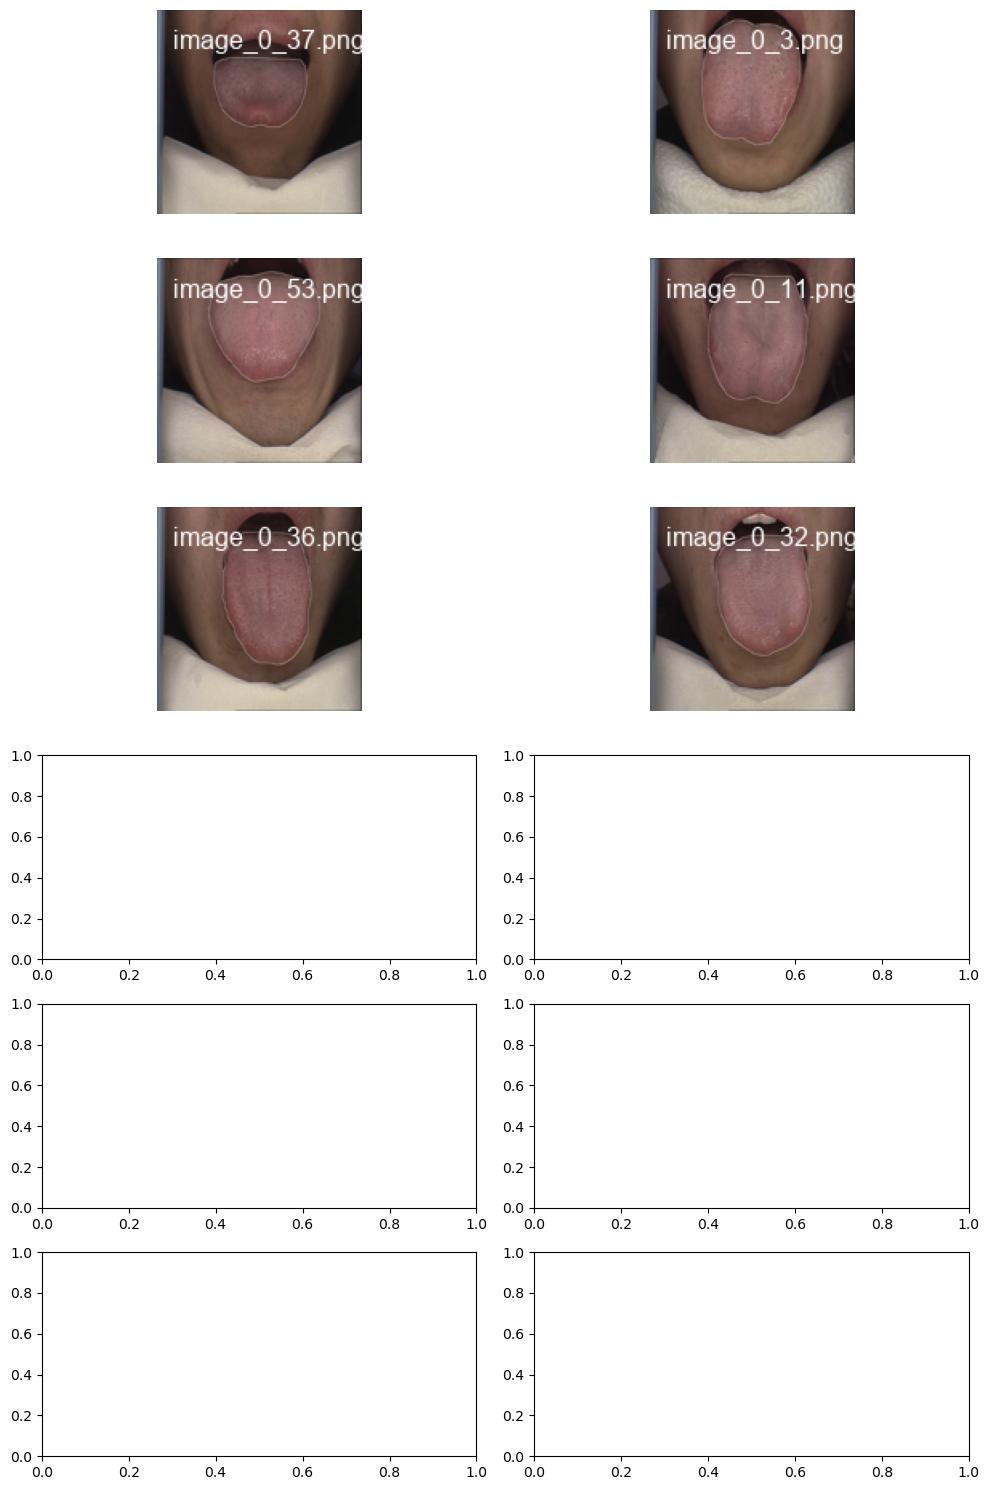

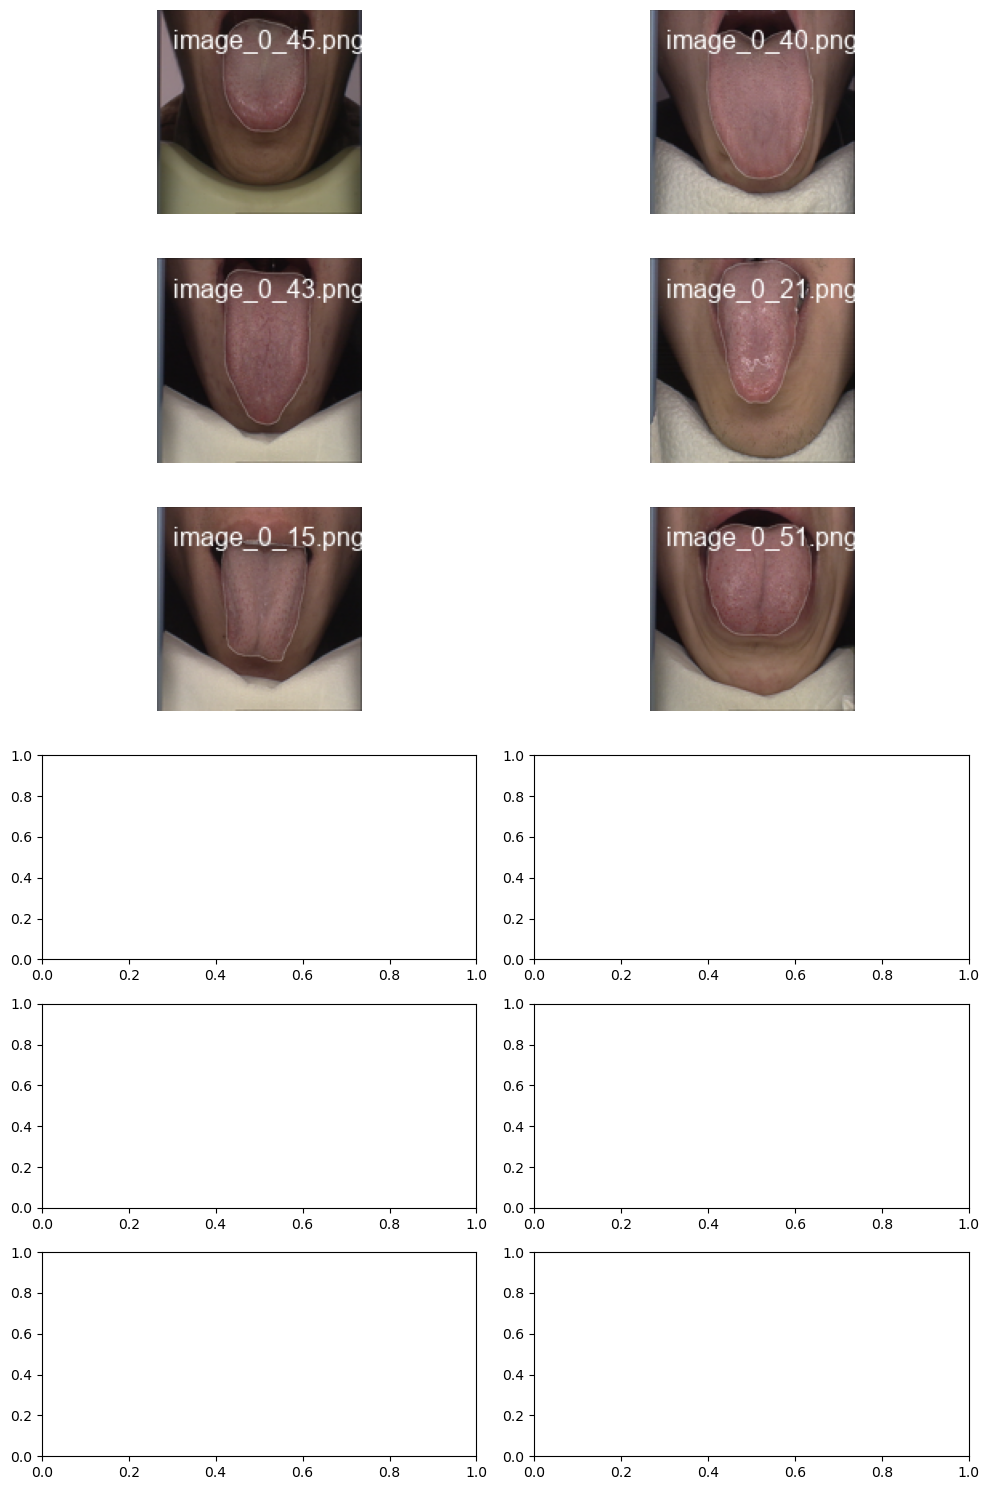

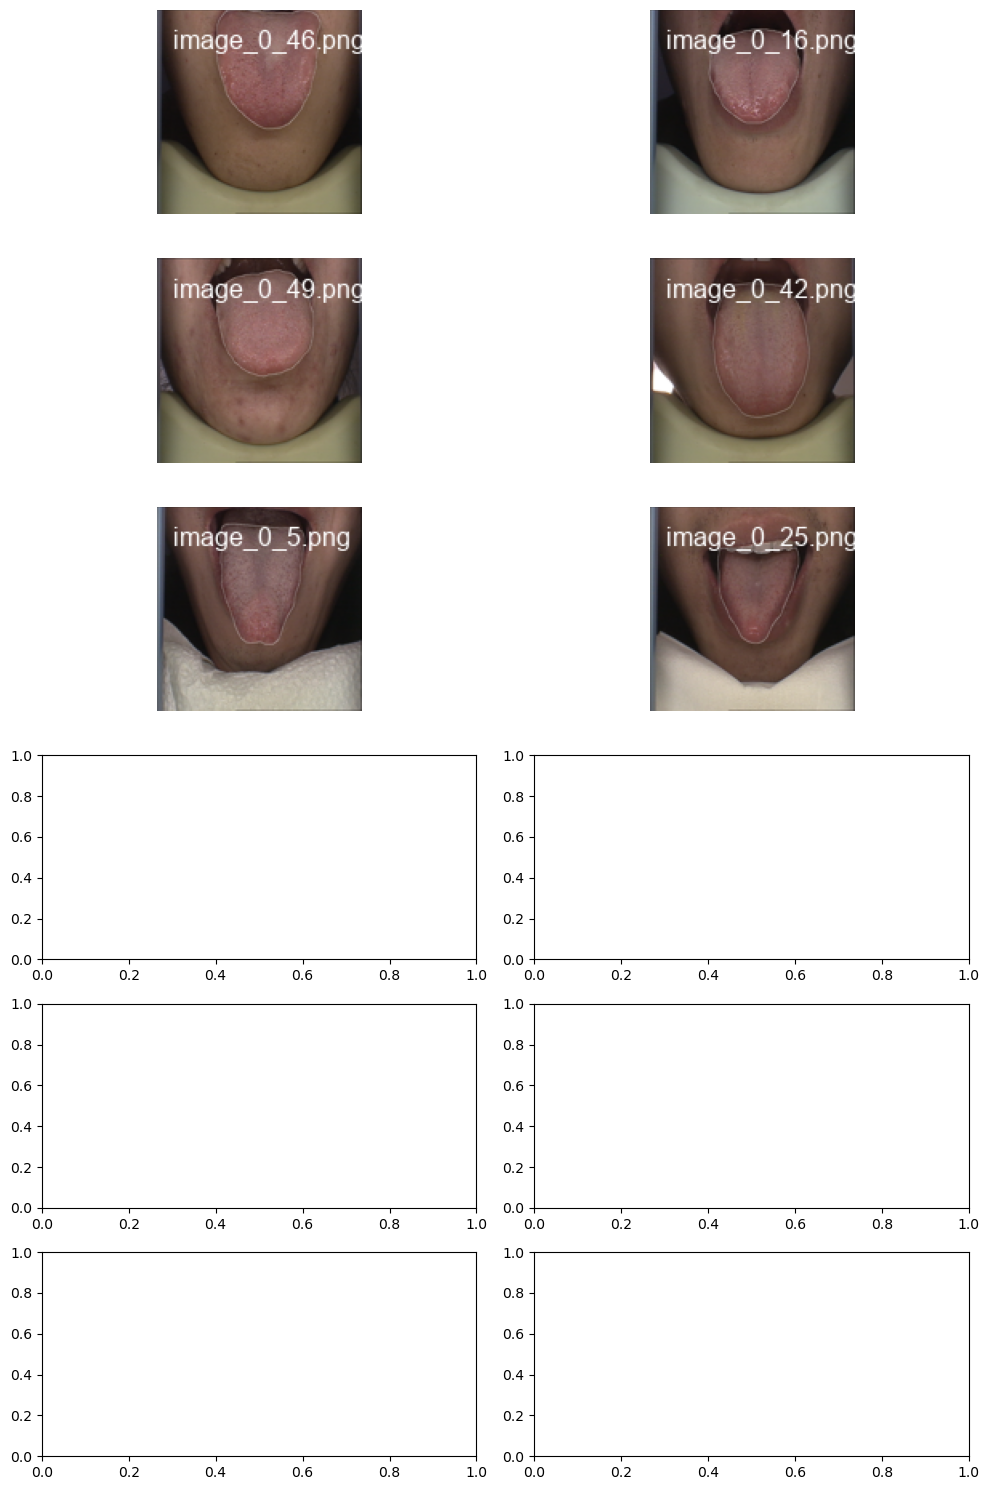

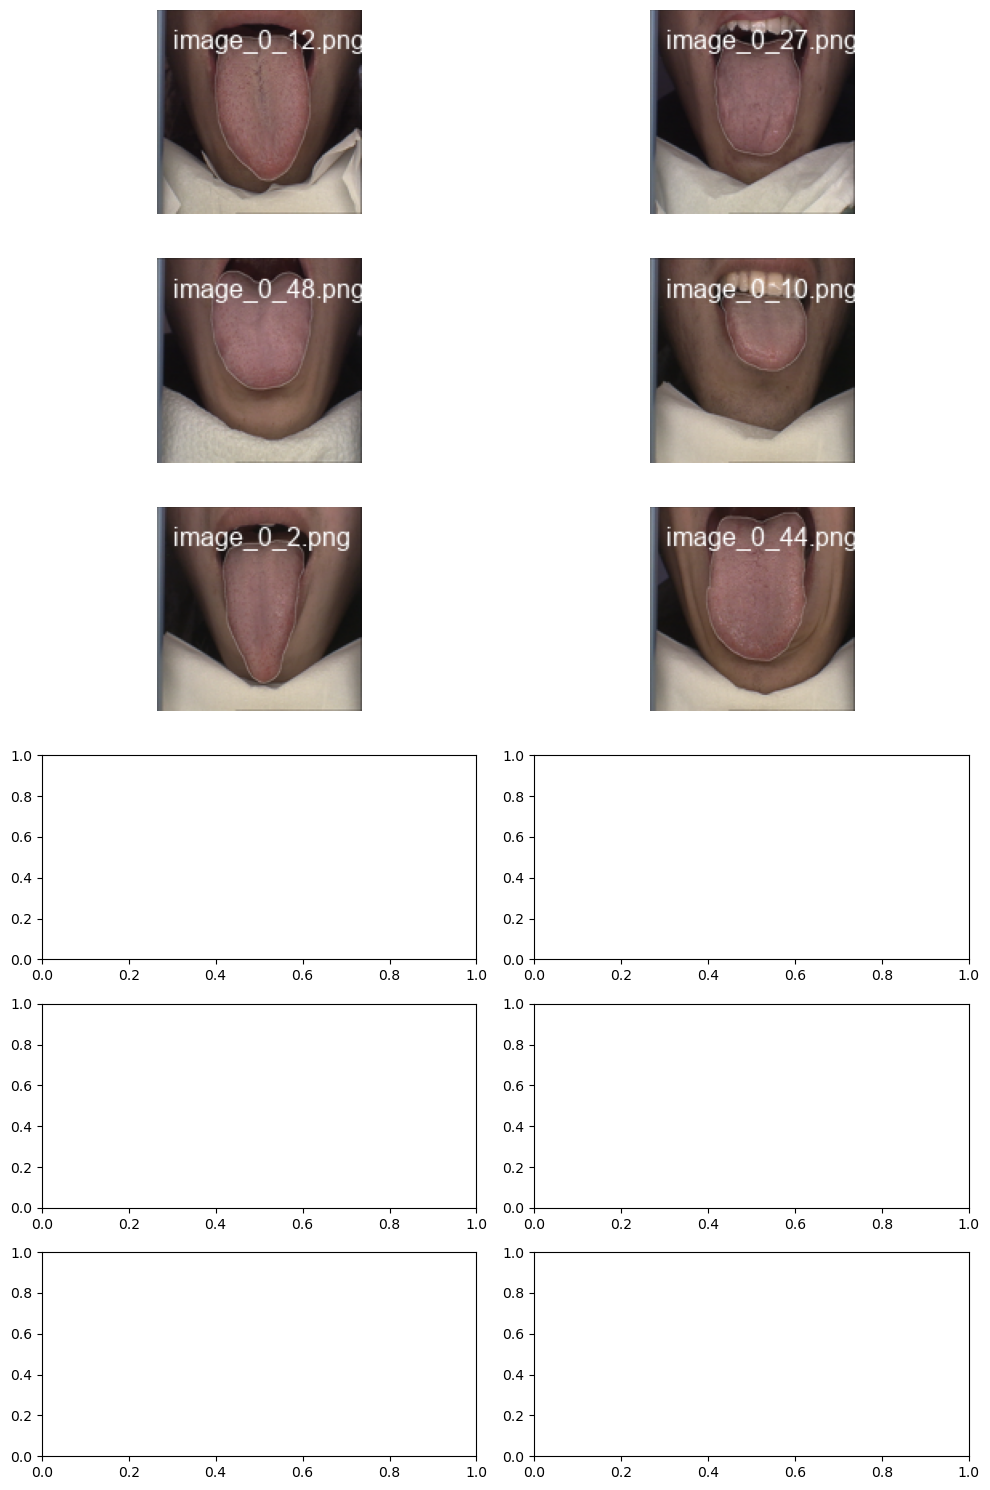

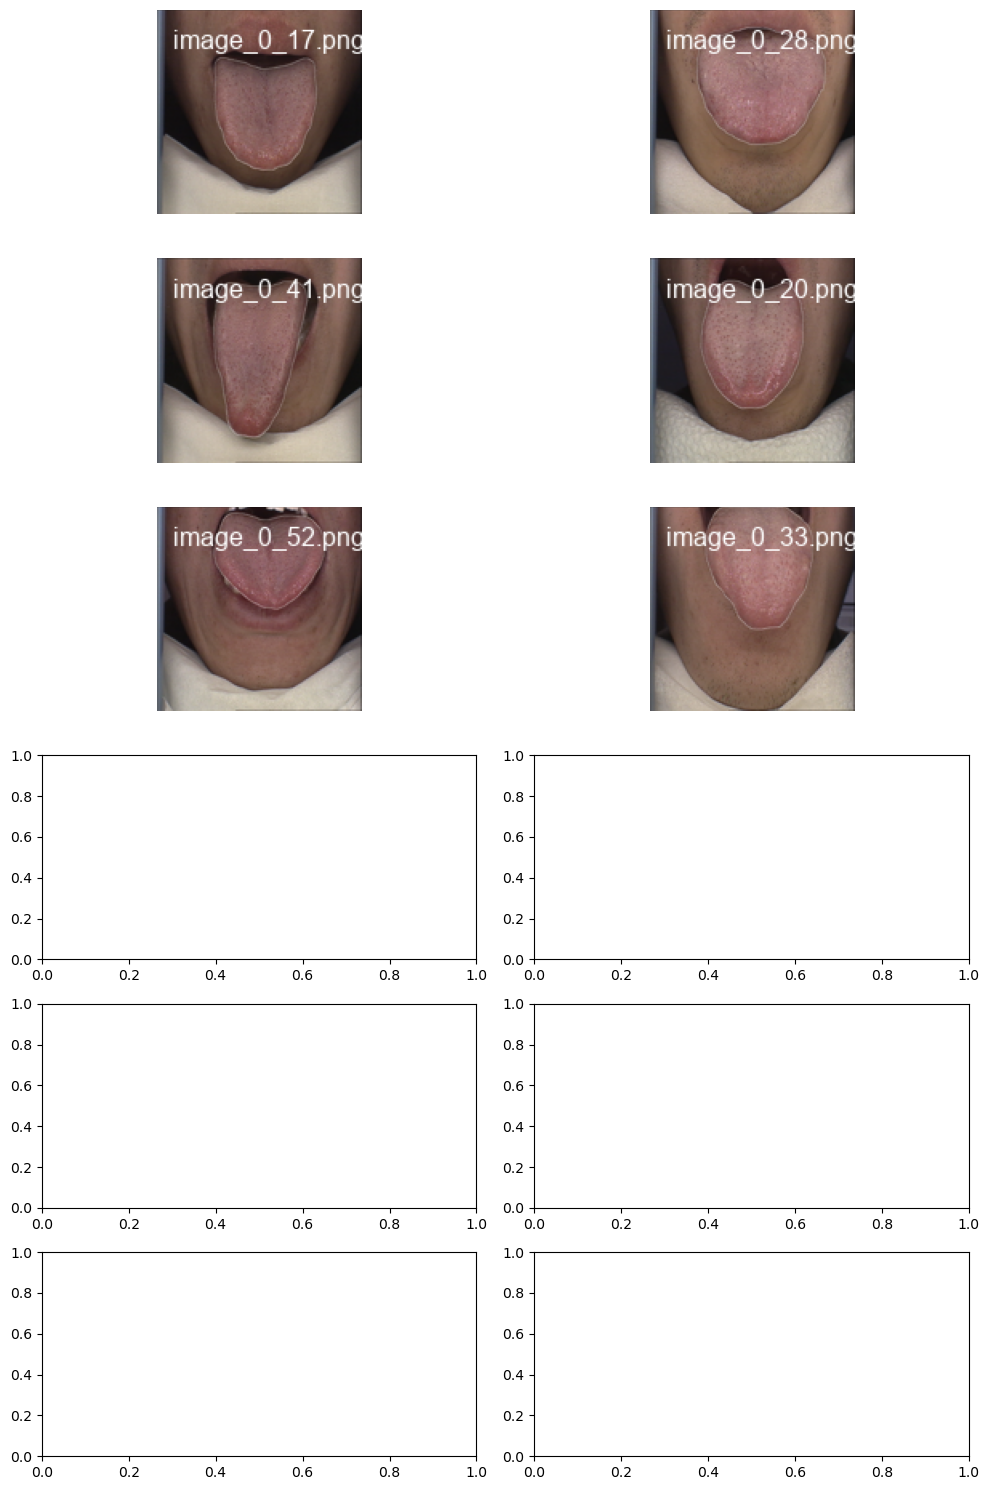

In [22]:
display_images_with_labels(unet_prediction_output_dir, total_images=18, images_per_page=6, num_pages=5)